In [1]:
import numpy as np
from numpy.linalg import matrix_power, matrix_rank
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import galois
from mec import make_circle
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.stats import skew

In [2]:
codes = [
    [6,6,3,1,2,3,1,2],
    [15,3,9,1,2,0,2,7],
    [9,6,3,1,2,3,1,2],
    [12,6,3,1,2,3,1,2],
    [12,12,3,2,7,3,1,2],
    [30,6,9,1,2,3,25,26],
    [21,18,3,10,17,5,3,19]
]
code = codes[1]

# 10,3,15,12,1,2,0,14,1,3,15,2,4,0.005,0.2,10001,9654,0.9653034696530348,3.8078865529319543,0.5207281650657156,8

# 10,6,30,27,5,4,3,29,28,6,30,2,1,0.005,0.1,10001,9810,0.9809019098090191,22,0.5983388736689147,12
# 10,6,30,21,1,2,3,13,26,6,30,2,2,0.005,0.1,10001,9799,0.9798020197980202,22,0.592000979396152,12


code = [3,15,12,1,2,0,14,1,3,15,2,4]
# code = [6,30,21,1,2,3,13,26,6,30,2,2]
code = [3,7,0,2,1,0,5,1]

In [3]:
def cyclic_shift_matrix(l):
    arr = np.eye(l, dtype=int)
    return np.roll(arr, axis=1, shift=1)

ell = code[1]
m = code[0]

x = np.kron(cyclic_shift_matrix(ell), np.eye(m))
y = np.kron(np.eye(ell), cyclic_shift_matrix(m))

In [4]:
A1 = matrix_power(x, code[2])
A2 = matrix_power(y, code[3])
A3 = matrix_power(y, code[4])
A = ( A1 + A2 + A3 ) % 2

B1 = matrix_power(y, code[5])
B2 = matrix_power(x, code[6])
B3 = matrix_power(x, code[7])
B = ( B1 + B2 + B3 ) % 2

In [5]:
Hx = np.hstack([A, B]).astype(int)
Hz = np.hstack([B.T, A.T]).astype(int)
# H = np.vstack([Hx, Hz])

In [6]:
GF = galois.GF(2)
arr = GF(Hz.T)
print(f"k = {2 * (Hz.T.shape[1] - matrix_rank(arr))}")

C:\Users\nfber\AppData\Roaming\Python\Python38\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


k = 12


In [7]:
def has_toric_layout():
    # As = [A1 @ A2.T, A2 @ A3.T, A1 @ A3.T]  # A2 @ A3.T cycling up, A3 @ A2.T cycling up, etc.
    # Bs = [B1 @ B2.T, B2 @ B3.T, B1 @ B3.T]
    As = [A1 @ A2.T, A2 @ A1.T, A2 @ A3.T, A3 @ A2.T, A1 @ A3.T, A3 @ A1.T ]
    Bs = [B1 @ B2.T, B2 @ B1.T, B2 @ B3.T, B3 @ B2.T, B1 @ B3.T, B3 @ B1.T]


    def has_toric_layout1():
        def order(arr):
            for i in range(1, m*ell):
                if not np.any(np.eye(arr.shape[0]) - np.linalg.matrix_power(arr, i)):
                    return i
            return -1

        Aorders = [order(AA) for AA in As]
        Borders = [order(BB) for BB in Bs]

        pot_orders = []
        for i, Ao in enumerate(Aorders):
            for j, Bo in enumerate(Borders):
                if (Ao*Bo == m*ell):
                    pot_orders.append((Ao,Bo,i,j))
        return pot_orders

    def has_toric_layout2(pot_codes):
        emb_m, emb_ell, A_ind, B_ind = pot_codes

        visited_qbts = set()

        ver = csr_matrix(As[A_ind])
        hor = csr_matrix(Bs[B_ind])

        for i in range(emb_m):
            tmp_qbt = (ver**i)[0].indices[0] if i else 0
            for j in range(emb_ell):
                visited_qbts |= {(hor**j)[tmp_qbt].indices[0] if j else tmp_qbt}

        return len(visited_qbts) == ell*m

    confirmed_codes = []
    pot_codes = has_toric_layout1()
    for pot_code in pot_codes:
        if has_toric_layout2(pot_code):
            confirmed_codes.append(pot_code)
    return confirmed_codes

confirmed_codes = has_toric_layout()
print(confirmed_codes)

[(3, 7, 0, 0), (3, 7, 0, 1), (3, 7, 0, 2), (3, 7, 0, 3), (3, 7, 0, 4), (3, 7, 0, 5), (3, 7, 1, 0), (3, 7, 1, 1), (3, 7, 1, 2), (3, 7, 1, 3), (3, 7, 1, 4), (3, 7, 1, 5), (3, 7, 2, 0), (3, 7, 2, 1), (3, 7, 2, 2), (3, 7, 2, 3), (3, 7, 2, 4), (3, 7, 2, 5), (3, 7, 3, 0), (3, 7, 3, 1), (3, 7, 3, 2), (3, 7, 3, 3), (3, 7, 3, 4), (3, 7, 3, 5), (3, 7, 4, 0), (3, 7, 4, 1), (3, 7, 4, 2), (3, 7, 4, 3), (3, 7, 4, 4), (3, 7, 4, 5), (3, 7, 5, 0), (3, 7, 5, 1), (3, 7, 5, 2), (3, 7, 5, 3), (3, 7, 5, 4), (3, 7, 5, 5)]


In [8]:
def embed_code(code, init):
    emb_m, emb_ell, A_ind, B_ind = code

    lattice = np.empty((2*emb_m, 2*emb_ell), dtype=object)
    lattice[0][0] = f"x{init}"

    # As = [[A1, A2.T], [A2, A3.T], [A1, A3.T]]
    # Bs = [[B1, B2.T], [B2, B3.T], [B1, B3.T]]
    As = [[A1, A2.T], [A2, A1.T], [A2, A3.T], [A3, A2.T], [A1, A3.T], [A3, A1.T]]
    Bs = [[B1, B2.T], [B2, B1.T], [B2, B3.T], [B3, B2.T], [B1, B3.T], [B3, B1.T]]

    def get_nbr(i, j):
        if (i % 2 == 0):
            if (j % 2 == 0):
                return "x"
            else:
                return "r"
        else:
            if (j % 2 == 0):
                return "l"
            else:
                return "z"

    for i in range(2*emb_m - 1):
        for j in range(2*emb_ell):
            curr_ind = int(lattice[i][j][1:])

            if (i % 2 == 0):
                tmp_A = As[A_ind][1]
            else:
                tmp_A = As[A_ind][0]
            if (j % 2 == 0):
                tmp_B = Bs[B_ind][1]
            else:
                tmp_B = Bs[B_ind][0]

            lattice[(i+1)%(2*emb_m)][j] = f"{get_nbr((i+1)%(2*emb_m), j)}{np.where(tmp_A @ np.eye(m*ell)[curr_ind])[0][0]}"
            lattice[i][(j+1)%(2*emb_ell)] = f"{get_nbr(i, (j+1)%(2*emb_ell))}{np.where(tmp_B @ np.eye(m*ell)[curr_ind])[0][0]}"

    for i in range(2*emb_m):
        for j in range(2*emb_ell):
            if (lattice[i][j][0] == "z"):
                lattice[i][j] = f"z{int(lattice[i][j][1:]) + m*ell}"
            elif (lattice[i][j][0] == "r"):
                lattice[i][j] = f"r{int(lattice[i][j][1:]) + m*ell}"

    return lattice

In [9]:
for c,code in enumerate(confirmed_codes):
    lattice = embed_code(code, 0)

    colors = np.empty(lattice.shape, dtype=object)
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "x":
                colors[i][j] = "red"
            elif lattice[i][j][0] == "r":
                colors[i][j] = "orange"
            elif lattice[i][j][0] == "l":
                colors[i][j] = "blue"
            else:
                colors[i][j] = "green"

    qbts = np.array([None for i in range(2*m*ell)])
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):
            if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
                qbts[int(lattice[i][j][1:])] = (i, j)

    rs = []
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hx[i])[0]]
        rs.append(make_circle(gen_qbts)[2])
    for i in range(m*ell):
        gen_qbts = qbts[np.where(Hz[i])[0]]
        rs.append(make_circle(gen_qbts)[2])

    print(c, code, skew(rs))
    # scaled_rs = [(r - min(rs)) / (max(rs) - min(rs)) for r in rs]

    # bins = np.linspace(min(scaled_rs), max(scaled_rs), 20)
    # counts, _ = np.histogram(scaled_rs, bins=bins)
    # counts_weighter = counts.sum()

    # print(code, sum([x*y for x,y in zip(counts/counts_weighter, bins[:-1])]))
    # print(code, np.percentile(scaled_rs, 70))
    # plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, label=f"{code}", alpha=0.7)
    # plt.legend()

0 (3, 7, 0, 0) 0.7458471567304339
1 (3, 7, 0, 1) 0.7458471567304338
2 (3, 7, 0, 2) 0.7458471567304338
3 (3, 7, 0, 3) 0.7458471567304339
4 (3, 7, 0, 4) 0.7458471567304339
5 (3, 7, 0, 5) 0.7458471567304358
6 (3, 7, 1, 0) 0.7458471567304333
7 (3, 7, 1, 1) 0.7458471567304313
8 (3, 7, 1, 2) 0.7458471567304338
9 (3, 7, 1, 3) 0.7458471567304337
10 (3, 7, 1, 4) 0.7458471567304337
11 (3, 7, 1, 5) 0.7458471567304341
12 (3, 7, 2, 0) 0.7458471567304333
13 (3, 7, 2, 1) 0.7458471567304313
14 (3, 7, 2, 2) 0.7458471567304338
15 (3, 7, 2, 3) 0.7458471567304337
16 (3, 7, 2, 4) 0.7458471567304337
17 (3, 7, 2, 5) 0.7458471567304341
18 (3, 7, 3, 0) 0.7458471567304337
19 (3, 7, 3, 1) 0.7458471567304337
20 (3, 7, 3, 2) 0.7458471567304338
21 (3, 7, 3, 3) 0.7458471567304338
22 (3, 7, 3, 4) 0.7458471567304337
23 (3, 7, 3, 5) 0.7458471567304339
24 (3, 7, 4, 0) 0.7458471567304339
25 (3, 7, 4, 1) 0.7458471567304338
26 (3, 7, 4, 2) 0.7458471567304338
27 (3, 7, 4, 3) 0.7458471567304339
28 (3, 7, 4, 4) 0.745847156730

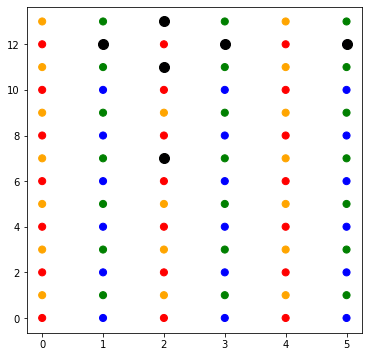

In [14]:
lattice = embed_code(confirmed_codes[4], 0)

colors = np.empty(lattice.shape, dtype=object)

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            colors[i][j] = "red"
        elif lattice[i][j][0] == "r":
            colors[i][j] = "orange"
        elif lattice[i][j][0] == "l":
            colors[i][j] = "blue"
        else:
            colors[i][j] = "green"

qbts = np.array([None for i in range(2*m*ell)])
for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "r" or lattice[i][j][0] == "l":
            qbts[int(lattice[i][j][1:])] = (i, j)
x_checks = np.array([None for i in range(m*ell)])
z_checks = np.array([None for i in range(m*ell)])

for i in range(lattice.shape[0]):
    for j in range(lattice.shape[1]):
        if lattice[i][j][0] == "x":
            x_checks[int(lattice[i][j][1:])] = (i, j)
        elif lattice[i][j][0] == "z":
            z_checks[int(lattice[i][j][1:])-(m*ell)] = (i, j)



nodes = itertools.product(np.arange(lattice.shape[0]), np.arange(lattice.shape[1]))

gen_qbts = qbts[np.where(Hx[20])[0]]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*zip(*nodes), s=50, c=colors.flatten()) # vv qubits
ax.scatter(*zip(*gen_qbts), s=100, c='k')

10 0


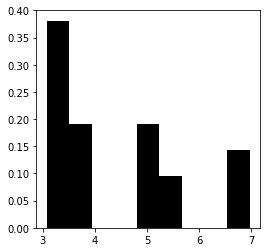

In [11]:
x_rs = []
z_rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    x_rs.append(make_circle(gen_qbts)[2])
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hz[i])[0]]
    z_rs.append(make_circle(gen_qbts)[2])

fig, ax = plt.subplots(1, 1, figsize=(4,4))
rs = x_rs
bins = np.linspace(min(rs), max(rs), 10)
counts, _ = np.histogram(rs, bins=bins)
counts_weighter = counts.sum()
ax.hist(bins[:-1], bins=bins, weights=counts/counts_weighter, color='black')
print(np.argmin(rs), np.argmax(rs))

In [12]:
for i in range(m*ell):
    nlqbts = []
    coord = x_checks[i]
    gen_qbts = qbts[np.where(Hx[i])[0]]
    for qbt in gen_qbts:
        if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
            nlqbts.append(qbt)
    if make_circle(gen_qbts)[2] < (min(x_rs)+np.std(x_rs)):
        print([nlqbts, coord])

for i in range(m*ell):
    nlqbts = []
    coord = z_checks[i]
    gen_qbts = qbts[np.where(Hz[i])[0]]
    for qbt in gen_qbts:
        if (abs(coord[0]-qbt[0])+ abs(coord[1]-qbt[1]) > 1):
            nlqbts.append(qbt)
    if make_circle(gen_qbts)[2] < (min(z_rs)+np.std(z_rs)):
        print([nlqbts, coord])

[[(3, 0), (5, 6), (0, 3)], (0, 6)]
[[(5, 0), (2, 3)], (2, 6)]
[[(1, 0), (4, 3)], (4, 6)]
[[(3, 2), (5, 8), (0, 5)], (0, 8)]
[[(5, 2), (2, 5)], (2, 8)]
[[(1, 2), (4, 5)], (4, 8)]
[[(3, 4), (5, 10), (0, 7)], (0, 10)]
[[(5, 4), (2, 7)], (2, 10)]
[[(1, 4), (4, 7)], (4, 10)]
[[(3, 6), (5, 12), (0, 9)], (0, 12)]
[[(5, 6), (2, 9)], (2, 12)]
[[(1, 6), (4, 9)], (4, 12)]
[[(3, 8), (5, 14), (0, 11)], (0, 14)]
[[(5, 8), (2, 11)], (2, 14)]
[[(1, 8), (4, 11)], (4, 14)]
[[(3, 10), (5, 16), (0, 13)], (0, 16)]
[[(5, 10), (2, 13)], (2, 16)]
[[(1, 10), (4, 13)], (4, 16)]
[[(3, 12), (5, 18), (0, 15)], (0, 18)]
[[(5, 12), (2, 15)], (2, 18)]
[[(1, 12), (4, 15)], (4, 18)]
[[(3, 14), (5, 20), (0, 17)], (0, 20)]
[[(5, 14), (2, 17)], (2, 20)]
[[(1, 14), (4, 17)], (4, 20)]
[[(3, 16), (5, 22), (0, 19)], (0, 22)]
[[(5, 16), (2, 19)], (2, 22)]
[[(1, 16), (4, 19)], (4, 22)]
[[(3, 18), (5, 24), (0, 21)], (0, 24)]
[[(5, 18), (2, 21)], (2, 24)]
[[(1, 18), (4, 21)], (4, 24)]
[[(3, 20), (5, 26), (0, 23)], (0, 26)]
[[(5, 

263.9371764191945


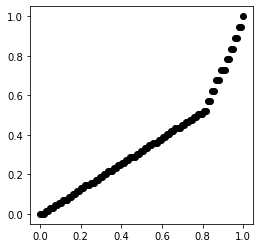

In [13]:
rs = []
for i in range(m*ell):
    gen_qbts = qbts[np.where(Hx[i])[0]]
    rs.append(make_circle(gen_qbts)[2])
# for i in range(m*ell):
#     gen_qbts = qbts[np.where(Hz[i])[0]]
#     rs.append(make_circle(gen_qbts)[2])

# bins = np.linspace(min(rs), max(rs), 20)
# counts, _ = np.histogram(rs, bins=bins)
# counts_weighter = counts.sum()
# plt.hist(bins[:-1], bins=bins, weights=counts/counts_weighter)
rs = sorted(rs)
print(sum(rs))

fig, ax = plt.subplots(1, 1, figsize=(4,4))
work = [sum((rs)[:int(i*len(rs))])/sum(rs) for i in np.linspace(0,1,100)]
plt.scatter(np.linspace(0,1,100), work, c='k')

In [15]:
arr = []
for i, x in enumerate(x_rs):
    if (x > (min(x_rs))+np.std(x_rs)):
        arr.append(i)
x_mask = np.zeros(Hx.shape[0]).astype(np.uint8)
x_mask[arr] = 1

Hxm = Hx[x_mask == 0]

print(arr)
print(len(arr)/Hx.shape[0])

arr = []
for i, z in enumerate(z_rs):
    if (z > (min(z_rs))+np.std(z_rs)):
        arr.append(i)

z_mask = np.zeros(Hz.shape[0]).astype(np.uint8)
z_mask[arr] = 1

Hzm = Hz[z_mask == 0]
print(arr)
print(len(arr)/Hz.shape[0])

[0, 1, 2, 3, 4, 5, 6, 7, 8]
0.2
[0, 1, 2, 39, 40, 41, 42, 43, 44]
0.2


In [17]:
for i in range(Hxm.shape[1]):
    print(np.count_nonzero(Hxm[:,i]))

1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
1
1
1
0
0
0
1
1
1
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2


In [413]:
df = pd.read_csv("./codes/30_6/codes.csv")

mins = [44,44,44,44,44,44,44,44,64,64,64,64,44,44,44,44,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,64,64,64,64,44,44,44,44,64,64,64,44,44,44,44,64,64,64,64,44,44,44,44,46,46,46,46,46,46,46,46,44,44,44,44,64,64,64,64,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,52,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,64,64,64,64,44,44,44,44,64,64,64,64,46,46,46,46,46,46,46,46,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,64,64,64,64,44,44,44,44,60,60,60,60,60,60,60,60,60,60,60,60,60,60,64,64,64,64,44,44,44,44,52,44,44,44,44,44,44,44,44,46,46,46,46,46,46,46,46,46,46,46,46,22,22,22,22,22,22,28,28,28,28,28,28,22,22,22,22,22,22,22,46,46,46,46,22,22,22,22,22,22,34,34,28,28,28,28,28,34,34,34,34,34,46,46,46,46,22,22,22,22,22,22,22]
min_df = pd.DataFrame(mins)
adv = [0.7992381079333173,0.8003014596993163,0.7998652819218881,0.800930296685672,0.7998652819218883,0.8009302966856721,0.7992381079333174,0.8003014596993164,0.842662023547059,0.7959328041711955,0.8428335230105849,0.7962045312528246,0.8403442557734749,0.8397476650261264,0.8400366023067515,0.8394289662640672,0.8027838899464619,0.7595514577047942,0.8027838899464619,0.759551457704794,0.802842170329123,0.7595869981127362,0.8028421703291232,0.7595869981127362,0.8028421703291232,0.7595869981127364,0.8028421703291233,0.7595869981127366,0.8027838899464621,0.7595514577047942,0.802783889946462,0.7595514577047942,0.7953997687300609,0.8422412670994662,0.7957913019456835,0.8425716023172518,0.8393693155187207,0.8399343898692638,0.838568744589218,0.8391143194412571,0.8425716023172519,0.7957913019456835,0.8422412670994658,0.8399343898692638,0.8393693155187207,0.8391143194412571,0.8385687445892182,0.842833523010585,0.7962045312528245,0.8426620235470591,0.7959328041711958,0.8400366023067517,0.8394289662640672,0.8403442557734749,0.8397476650261263,0.8392224311125152,0.8386952913054277,0.8395193132655281,0.838934936333695,0.8400957024990463,0.8395063173302744,0.8399778218046859,0.8393620423430644,0.8403442557734749,0.8397476650261262,0.8400366023067516,0.8394289662640672,0.8426620235470592,0.7959328041711958,0.842833523010585,0.7962045312528249,0.802783889946462,0.7595514577047942,0.8027838899464619,0.759551457704794,0.8028421703291231,0.7595869981127363,0.8028421703291231,0.7595869981127362,0.8028421703291233,0.7595869981127364,0.8028421703291233,0.8027838899464621,0.7595514577047943,0.8027838899464621,0.7595514577047942,0.7043661633760023,0.7992381079333173,0.8003014596993163,0.7998652819218883,0.8009302966856721,0.7998652819218883,0.8009302966856721,0.7992381079333176,0.8003014596993164,0.8003014596993164,0.7992381079333175,0.8009302966856722,0.7998652819218883,0.8003014596993164,0.7992381079333174,0.8009302966856721,0.7998652819218884,0.8400366023067516,0.8394289662640673,0.8403442557734748,0.8397476650261263,0.8426620235470591,0.7959328041711958,0.842833523010585,0.7962045312528248,0.8400366023067516,0.8394289662640673,0.8403442557734747,0.8397476650261261,0.842662023547059,0.795932804171196,0.8428335230105851,0.7962045312528249,0.8399778218046859,0.8393620423430643,0.8400957024990463,0.8395063173302744,0.8395193132655283,0.838934936333695,0.8392224311125153,0.8386952913054277,0.802842170329123,0.7595869981127361,0.8028421703291231,0.7595869981127363,0.8027838899464619,0.759551457704794,0.802783889946462,0.7595514577047944,0.802842170329123,0.8028421703291232,0.802783889946462,0.8027838899464621,0.7595514577047943,0.8027838899464614,0.802783889946462,0.7595514577047942,0.802842170329123,0.7595869981127363,0.8028421703291232,0.8028421703291226,0.7595869981127359,0.8028421703291232,0.8027838899464612,0.7595514577047934,0.8027838899464621,0.7595514577047942,0.802783889946462,0.8027838899464619,0.759551457704794,0.8028421703291232,0.7595869981127364,0.8028421703291232,0.7595869981127361,0.8028421703291234,0.8028421703291232,0.802783889946462,0.7595514577047942,0.8027838899464623,0.7953997687300611,0.8422412670994661,0.7957913019456836,0.8425716023172518,0.838568744589218,0.839114319441257,0.8393693155187204,0.8399343898692636,0.8028421703291231,0.7595869981127363,0.8028421703291231,0.8027838899464621,0.802783889946462,0.7595514577047939,0.8028421703291234,0.7595869981127363,0.8028421703291231,0.759586998112736,0.8027838899464621,0.7595514577047943,0.8027838899464619,0.759551457704794,0.8428335230105851,0.7962045312528249,0.8426620235470591,0.7959328041711958,0.8400366023067517,0.8394289662640674,0.840344255773475,0.8397476650261263,0.7043661633760024,0.7998652819218883,0.800930296685672,0.7992381079333174,0.8003014596993163,0.7998652819218883,0.8009302966856721,0.7992381079333174,0.8003014596993163,0.8389349363336951,0.8395193132655283,0.8386952913054277,0.839222431112515,0.8395063173302739,0.8400957024990462,0.8393620423430641,0.8399778218046856,0.7967003707788436,0.8435411768590422,0.797326800344111,0.84404541912477,0.5632355666526743,0.49954388916482,0.592000979396152,0.5528850417969887,0.5983388736689145,0.5193172262592416,0.49339778146767926,0.4875317598490551,0.5107509996534647,0.5124141893092747,0.5108737010583896,0.5127122292644739,0.5632355666526738,0.49954388916482007,0.5920009793961526,0.5128235489277855,0.5528850417969886,0.5983388736689147,0.5193172262592419,0.8440454191247695,0.7973268003441097,0.8435411768590418,0.7967003707788425,0.5193172262592418,0.5983388736689147,0.5128235489277854,0.5920009793961526,0.49954388916482007,0.5632355666526738,0.48963144991609114,0.487600188925015,0.5107509996534646,0.5108737010583895,0.5127122292644739,0.493397781467679,0.487531759849055,0.4649397118018983,0.4697996497020464,0.46764850671814034,0.48963144991609103,0.4876001889250149,0.7973268003441102,0.8440454191247704,0.796700370778843,0.8435411768590427,0.5128235489277847,0.5920009793961529,0.5632355666526743,0.49954388916481995,0.5193172262592414,0.5983388736689149,0.5528850417969888]
adv_df = pd.DataFrame(adv)
ks = [16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,16,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,12,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,12,16,16,16,16,16,16,16,16,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12]
ks_df = pd.DataFrame(ks)

df["min"] = min_df[0]
df["adv"] = adv_df[0]
df["k"] = ks_df[0]

sorted_df = df.sort_values(by=["p_log", "adv"], ascending=[False, True])
sorted_df.to_csv("./codes/30_6/sorted_codes.csv", index=None)

In [412]:
df = pd.read_csv("./codes/15_3/codes.csv")
mins = [22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,22,22,22,22,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,22,22,22,22,22,22,22,22,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,16,16,16,16,16]
min_df = pd.DataFrame(mins)
adv = [0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47023336317765685,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.47304903845056245,0.4058505036066713,0.46677589339979403,0.3997923961477754,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.39979239614777534,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4058505036066713,0.47304903845056256,0.39979239614777534,0.46677589339979403,0.47304903845056256,0.4058505036066713,0.46677589339979403,0.39979239614777534,0.39979239614777534,0.466775893399794,0.4058505036066712,0.4730490384505623,0.39979239614777545,0.46677589339979403,0.40585050360667113,0.47304903845056234,0.46424943813450353,0.4642494381345036,0.4702333631776568,0.47023336317765674,0.39979239614777534,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.40585050360667113,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.39979239614777534,0.466775893399794,0.4058505036066712,0.4730490384505623,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776568,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.39979239614777534,0.466775893399794,0.405850503606671,0.4730490384505622,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.39979239614777545,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47023336317765685,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.47304903845056245,0.46677589339979403,0.3997923961477754,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4058505036066712,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056245,0.39979239614777534,0.46677589339979403,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.39979239614777534,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.3997923961477754,0.46677589339979403,0.47304903845056245,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.40585050360667124,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.4058505036066713,0.47304903845056256,0.39979239614777534,0.46677589339979403,0.39979239614777534,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.40585050360667113,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.40585050360667113,0.47304903845056234,0.39979239614777545,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.4642494381345036,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.40585050360667113,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.47023336317765674,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47023336317765685,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.4730490384505623,0.405850503606671,0.46677589339979403,0.39979239614777534,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4730490384505625,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.4730490384505622,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.4730490384505625,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.4730490384505623,0.4058505036066712,0.466775893399794,0.39979239614777534,0.4730490384505623,0.405850503606671,0.46677589339979403,0.39979239614777534,0.4730490384505623,0.4058505036066712,0.466775893399794,0.39979239614777534,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46677589339979414,0.3997923961477754,0.4730490384505623,0.405850503606671,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979414,0.3997923961477754,0.4730490384505623,0.405850503606671,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.47304903845056245,0.4058505036066712,0.466775893399794,0.3997923961477754,0.4730490384505622,0.46677589339979403,0.3997923961477754,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.4730490384505622,0.40585050360667113,0.46677589339979403,0.3997923961477754,0.466775893399794,0.39979239614777534,0.4730490384505622,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.47023336317765696,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776568,0.47023336317765696,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776568,0.39979239614777534,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.405850503606671,0.4730490384505623,0.3997923961477754,0.46677589339979414,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.40585050360667124,0.47304903845056234,0.39979239614777545,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47023336317765685,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4058505036066712,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.4730490384505622,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.47304903845056245,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4058505036066712,0.4730490384505622,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.4730490384505622,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.39979239614777534,0.4702333631776566,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.47304903845056256,0.3997923961477754,0.466775893399794,0.47304903845056256,0.466775893399794,0.3997923961477754,0.46677589339979403,0.39979239614777545,0.47304903845056234,0.40585050360667113,0.47023336317765685,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4730490384505622,0.4058505036066712,0.47304903845056234,0.4058505036066711,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.46677589339979403,0.39979239614777545,0.47304903845056234,0.40585050360667113,0.4730490384505625,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.4730490384505623,0.40585050360667113,0.46677589339979403,0.39979239614777534,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4730490384505622,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.4730490384505623,0.405850503606671,0.46677589339979403,0.39979239614777534,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.466775893399794,0.39979239614777534,0.4730490384505623,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.4058505036066711,0.46677589339979403,0.3997923961477754,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.4730490384505622,0.40585050360667113,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.39979239614777545,0.47304903845056234,0.46677589339979403,0.39979239614777545,0.4730490384505622,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.4642494381345036,0.4702333631776568,0.47023336317765674,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.4730490384505622,0.466775893399794,0.39979239614777534,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.43165904290810947,0.4353313830772345,0.43165904290810936,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810936,0.43533138307723446,0.5207281650657156,0.49252130317051573,0.5207281650657156,0.429645293106406,0.49252130317051573,0.5207281650657156,0.49252130317051573,0.5207281650657156,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43533138307723446,0.43165904290810936,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810936,0.4353313830772345,0.43165904290810947,0.43165904290810936,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810936,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.5207281650657157,0.42964529310640603,0.49252130317051585,0.5207281650657157,0.49252130317051585,0.49252130317051573,0.429645293106406,0.5207281650657156,0.5207281650657156,0.49252130317051573,0.5207281650657156,0.5207281650657156,0.5207281650657156,0.49252130317051573,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.429645293106406,0.5207281650657156,0.49252130317051573,0.429645293106406,0.5207281650657156,0.49252130317051573,0.43533138307723446,0.43165904290810936,0.43165904290810947,0.4353313830772345,0.43533138307723446,0.43165904290810936,0.43165904290810947,0.4353313830772345,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810936,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810936,0.49252130317051585,0.5207281650657157,0.5207281650657157,0.49252130317051573,0.5207281650657156,0.429645293106406,0.49252130317051573,0.5207281650657156,0.429645293106406,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810936,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810936,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.5207281650657157,0.42964529310640603,0.5207281650657157,0.42964529310640603,0.5207281650657157,0.42964529310640603,0.49252130317051585,0.5207281650657157,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810936,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810936,0.42964529310640603,0.5207281650657157,0.49252130317051585,0.42964529310640603,0.5207281650657157,0.49252130317051573,0.5207281650657158,0.5207281650657158,0.42964529310640603,0.5207281650657157,0.429645293106406,0.5207281650657157,0.5207281650657157,0.49252130317051585,0.5207281650657157,0.49252130317051585,0.43165904290810964,0.43533138307723473,0.43165904290810936,0.43533138307723457,0.43165904290810964,0.43533138307723473,0.43165904290810936,0.43533138307723457,0.5207281650657158,0.49252130317051573,0.5207281650657158,0.49252130317051573,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.49252130317051573,0.5207281650657158,0.49252130317051573,0.5207281650657158,0.42964529310640603,0.43533138307723457,0.43165904290810936,0.43533138307723473,0.43165904290810964,0.43533138307723457,0.43165904290810936,0.43533138307723473,0.43165904290810964,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.49252130317051573,0.5207281650657158,0.5207281650657158,0.5207281650657157,0.5207281650657157,0.5207281650657157,0.429645293106406,0.5207281650657157,0.43533138307723473,0.43165904290810964,0.43533138307723457,0.43165904290810936,0.43533138307723473,0.43165904290810964,0.43533138307723457,0.43165904290810936,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.43533138307723457,0.43165904290810936,0.43165904290810964,0.43533138307723473,0.43533138307723457,0.43165904290810936,0.43165904290810964,0.43533138307723473,0.42964529310640603,0.5207281650657158,0.49252130317051573,0.42964529310640603,0.5207281650657158,0.5207281650657157,0.49252130317051585,0.429645293106406,0.5207281650657157,0.5207281650657157,0.429645293106406,0.49252130317051585,0.5207281650657157,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.43165904290810964,0.43533138307723473,0.43165904290810936,0.43533138307723457,0.43165904290810964,0.43533138307723473,0.43165904290810936,0.43533138307723457,0.5207281650657157,0.429645293106406,0.5207281650657157,0.43165904290810936,0.43533138307723457,0.43165904290810964,0.43533138307723473,0.43165904290810936,0.43533138307723457,0.43165904290810964,0.43533138307723473,0.43533138307723457,0.43165904290810936,0.43533138307723473,0.43165904290810964,0.43533138307723457,0.43165904290810936,0.43533138307723473,0.43165904290810964,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810936,0.43165904290810936,0.43533138307723446,0.43533138307723446,0.5207281650657158,0.49252130317051573,0.5207281650657158,0.49252130317051573,0.5207281650657158,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765674,0.4642494381345036,0.46424943813450353,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.4642494381345036,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4702333631776568,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.4730490384505625,0.4058505036066713,0.46677589339979414,0.39979239614777545,0.47304903845056234,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.4058505036066713,0.4730490384505625,0.3997923961477754,0.46677589339979414,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.39979239614777545,0.46677589339979414,0.40585050360667124,0.4730490384505624,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.3997923961477754,0.46677589339979403,0.4058505036066711,0.4730490384505623,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.4702333631776568,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765674,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.39979239614777545,0.46677589339979414,0.4058505036066713,0.47304903845056245,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4730490384505624,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.4058505036066713,0.4730490384505625,0.39979239614777545,0.46677589339979414,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.4702333631776568,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4642494381345034,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.40585050360667135,0.4730490384505625,0.39979239614777545,0.46677589339979414,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.4702333631776566,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.4642494381345036,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.47023336317765685,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.4642494381345036,0.46424943813450353,0.47023336317765685,0.47023336317765674,0.47023336317765674,0.47023336317765674,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4642494381345036,0.46424943813450353,0.4642494381345036,0.46424943813450353,0.47023336317765685,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4702333631776568,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.46677589339979414,0.39979239614777545,0.4730490384505625,0.4058505036066713,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4730490384505623,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.3997923961477754,0.46677589339979403,0.47304903845056234,0.47023336317765674,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4702333631776568,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.4058505036066711,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4702333631776566,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.40585050360667124,0.4730490384505624,0.39979239614777545,0.46677589339979414,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.4702333631776566,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.4058505036066711,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.4730490384505624,0.40585050360667124,0.46677589339979414,0.39979239614777545,0.4730490384505623,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066711,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776568,0.4730490384505624,0.40585050360667124,0.46677589339979414,0.39979239614777545,0.4730490384505623,0.4058505036066711,0.46677589339979403,0.3997923961477754,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765685,0.4730490384505623,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.47023336317765674,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.4730490384505623,0.4058505036066711,0.46677589339979403,0.3997923961477754,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.4702333631776566,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979414,0.39979239614777545,0.47304903845056245,0.4058505036066713,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.4642494381345036,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.40585050360667124,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47023336317765674,0.4642494381345036,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.47304903845056245,0.40585050360667124,0.46677589339979414,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.4702333631776568,0.47023336317765685,0.46424943813450353,0.4642494381345036,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.4702333631776568,0.4642494381345036,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.47023336317765685,0.47023336317765685,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.46424943813450353,0.4642494381345036,0.47023336317765674,0.47023336317765685,0.4642494381345036,0.46424943813450353,0.47023336317765685,0.47023336317765674,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.4058505036066713,0.47304903845056245,0.39979239614777545,0.46677589339979414,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4058505036066713,0.47304903845056245,0.39979239614777545,0.46677589339979414,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.3997923961477754,0.46677589339979403,0.4730490384505623,0.4730490384505624,0.3997923961477754,0.46677589339979403,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.4730490384505624,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.4730490384505623,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.47023336317765674,0.4058505036066712,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.46677589339979414,0.3997923961477754,0.4730490384505625,0.4058505036066713,0.47304903845056234,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.46677589339979414,0.39979239614777545,0.4730490384505625,0.4058505036066713,0.47304903845056234,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.40585050360667124,0.47304903845056234,0.3997923961477754,0.46677589339979414,0.4058505036066713,0.4730490384505625,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.40585050360667124,0.47304903845056245,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979414,0.39979239614777545,0.4730490384505624,0.40585050360667124,0.4702333631776568,0.4702333631776568,0.46424943813450353,0.4642494381345036,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4730490384505623,0.40585050360667113,0.46677589339979403,0.3997923961477754,0.46677589339979414,0.39979239614777545,0.4730490384505624,0.40585050360667124,0.4642494381345036,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47023336317765674,0.47023336317765685,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.40585050360667124,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066712,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.4058505036066711,0.46677589339979403,0.39979239614777534,0.4730490384505623,0.47304903845056245,0.4058505036066713,0.46677589339979414,0.39979239614777545,0.46424943813450353,0.46424943813450353,0.4702333631776568,0.4702333631776566,0.47304903845056245,0.40585050360667124,0.46677589339979414,0.3997923961477754,0.4702333631776568,0.47023336317765674,0.46424943813450353,0.46424943813450353,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.47304903845056234,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46424943813450353,0.4642494381345036,0.4702333631776566,0.47023336317765674,0.47304903845056234,0.4058505036066712,0.466775893399794,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.4702333631776566,0.47023336317765674,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.40585050360667124,0.47023336317765674,0.4702333631776568,0.46424943813450353,0.4642494381345036,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.47304903845056245,0.40585050360667124,0.46677589339979403,0.3997923961477754,0.46424943813450353,0.46424943813450353,0.47023336317765674,0.4702333631776566,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47304903845056234,0.4058505036066712,0.46677589339979403,0.3997923961477754,0.47304903845056245,0.40585050360667124,0.46677589339979414,0.3997923961477754,0.46677589339979403,0.3997923961477754,0.4730490384505623,0.42964529310640603,0.5207281650657156,0.49252130317051573,0.42964529310640603,0.5207281650657156,0.49252130317051573,0.42964529310640603,0.5207281650657158,0.49252130317051585,0.42964529310640603,0.5207281650657158,0.49252130317051585,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4316590429081096,0.4353313830772346,0.4316590429081094,0.4353313830772345,0.4316590429081096,0.4353313830772346,0.4316590429081094,0.4353313830772345,0.4353313830772346,0.4316590429081096,0.4316590429081094,0.4353313830772345,0.4353313830772346,0.4316590429081096,0.4316590429081094,0.4353313830772345,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.49252130317051585,0.5207281650657158,0.42964529310640603,0.5207281650657158,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.5207281650657156,0.5207281650657156,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4353313830772345,0.4316590429081094,0.4316590429081096,0.4353313830772346,0.4353313830772345,0.4316590429081094,0.4316590429081096,0.4353313830772346,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.42964529310640603,0.5207281650657156,0.49252130317051573,0.5207281650657156,0.49252130317051573,0.4353313830772345,0.4316590429081094,0.4353313830772346,0.4316590429081096,0.4353313830772345,0.4316590429081094,0.4353313830772346,0.4316590429081096,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.5207281650657158,0.49252130317051585,0.4316590429081096,0.4353313830772346,0.4316590429081094,0.4353313830772345,0.4316590429081096,0.4353313830772346,0.4316590429081094,0.4353313830772345,0.5207281650657156,0.5207281650657156,0.49252130317051585,0.5207281650657158,0.42964529310640603,0.49252130317051585,0.5207281650657158,0.42964529310640603,0.5207281650657158,0.49252130317051585,0.5207281650657158,0.5207281650657158,0.42964529310640603,0.5207281650657158,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4353313830772345,0.4316590429081094,0.4316590429081096,0.4353313830772346,0.4353313830772345,0.4316590429081094,0.4316590429081096,0.4353313830772346,0.4168716885252487,0.5207281650657156,0.42964529310640603,0.5207281650657156,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4316590429081094,0.4353313830772345,0.4316590429081096,0.4353313830772346,0.4316590429081094,0.4353313830772345,0.4316590429081096,0.4353313830772346,0.5207281650657156,0.49252130317051573,0.5207281650657156,0.42964529310640603,0.42964529310640587,0.5207281650657157,0.49252130317051585,0.5207281650657157,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4316590429081094,0.4316590429081094,0.43533138307723446,0.43533138307723446,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.49252130317051573,0.42964529310640603,0.5207281650657157,0.49252130317051573,0.42964529310640603,0.5207281650657157,0.5207281650657157,0.42964529310640603,0.5207281650657157,0.42964529310640603,0.4353313830772345,0.43165904290810947,0.43165904290810947,0.43533138307723446,0.4353313830772345,0.43165904290810947,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4316590429081094,0.4316590429081094,0.43533138307723446,0.43533138307723446,0.42964529310640587,0.5207281650657157,0.5207281650657157,0.49252130317051585,0.5207281650657157,0.43165904290810947,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.5207281650657157,0.49252130317051573,0.5207281650657157,0.49252130317051573,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.4316590429081094,0.4316590429081094,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.43165904290810947,0.43533138307723446,0.43165904290810947,0.4353313830772345,0.5207281650657157,0.42964529310640587,0.49252130317051585,0.5207281650657157,0.49252130317051585,0.42964529310640587,0.5207281650657157,0.49252130317051585,0.5207281650657157,0.5207281650657157,0.49252130317051573,0.42964529310640603,0.5207281650657157,0.49252130317051573,0.49252130317051573,0.5207281650657157,0.42964529310640603,0.49252130317051573,0.5207281650657157,0.42964529310640603,0.4353313830772345,0.43165904290810947,0.43165904290810947,0.43533138307723446,0.4353313830772345,0.43165904290810947,0.43165904290810947,0.43533138307723446,0.4316590429081094,0.4316590429081094,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.5207281650657157,0.42964529310640603,0.49252130317051573,0.5207281650657157,0.42964529310640603,0.49252130317051573,0.5207281650657157,0.42964529310640603,0.49252130317051573,0.5207281650657157,0.42964529310640603,0.42964529310640603,0.5207281650657157,0.5207281650657157,0.49252130317051573,0.4316590429081094,0.4316590429081094,0.43533138307723446,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.43533138307723457,0.43533138307723457,0.5207281650657157,0.49252130317051585,0.5207281650657157,0.5207281650657157,0.42964529310640587,0.4168716885252487,0.5207281650657157,0.42964529310640587,0.5207281650657157,0.5207281650657157,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.4353313830772345,0.43533138307723446,0.43165904290810947,0.43165904290810947,0.4353313830772345,0.5207281650657157,0.42964529310640587,0.49252130317051585,0.5207281650657157,0.42964529310640587]
adv_df = pd.DataFrame(adv)
ks = [8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
ks_df = pd.DataFrame(ks)

df["min"] = min_df[0]
df["adv"] = adv_df[0]
df["k"] = ks_df[0]

sorted_df = df.sort_values(by=["p_log", "adv"], ascending=[False, True])
sorted_df.to_csv("./codes/15_3/sorted_codes.csv", index=None)

In [414]:
df = pd.read_csv("./codes/30_3/codes.csv")
mins = [30,30,30,30,30,30,30,32,32,32,32,32,32,34,34,34,34,32,32,32,32,32,32,28,28,28,28,44,44,44,44,64,64,44,44,44,64,44,44,64,44,44,64,64,64,64,44,44,64,44,44,44,44,44,44,44,64,64,64,64,64,64,44,44,44,44,64,44,64,64,44,44,44,64,64,44,44,44,44,44,44,44,44,44,32,32,32,32,30,30,30,30,30,34,34,34,34,34,34,34,38,38,38,38,38,22,22,22,22,22,22,22,22,28,28,28,28,28,28,28,28,28,28,28,30,30,30,30,34,34,34,34,34,34,34,34,34,34,34,34,24,24,24,24,40,40,40,40,40]
min_df = pd.DataFrame(mins)
ks = [8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
ks_df = pd.DataFrame(ks)
adv = [0.47497760250983223,0.44160717442040065,0.4764809063488479,0.4754257899180874,0.44190933252834314,0.44420871068445694,0.4790999782123945,0.438618175868999,0.4376483806075242,0.45720165999263984,0.4225541626692946,0.4552469854295032,0.4206493262071711,0.4541882736989243,0.45575291116338745,0.4557529111633875,0.45418827369892417,0.42255416266929474,0.45720165999263973,0.45524698542950315,0.43861817586899887,0.43764838060752415,0.4552469854295032,0.4969266047314461,0.44595150512368936,0.4969266047314461,0.44595150512368936,0.8390619411439335,0.83845714822391,0.8388380672763036,0.838248960606213,0.841789691333054,0.841789691333054,0.838838067276304,0.8382489606062133,0.8390619411439336,0.841789691333054,0.8382489606062135,0.8388380672763038,0.8417896913330536,0.8390619411439335,0.8382489606062132,0.8417896913330538,0.8417896913330539,0.8417896913330538,0.841789691333054,0.838838067276304,0.8384571482239104,0.8417896913330539,0.8388380672763036,0.8382489606062132,0.8390619411439336,0.8384571482239103,0.8388380672763037,0.8382489606062132,0.8384571482239103,0.8419039207891019,0.8417896913330536,0.8417896913330538,0.8417896913330539,0.8419039207891019,0.8417896913330538,0.8390619411439337,0.8384571482239104,0.8388380672763038,0.8382489606062135,0.8417896913330539,0.8388380672763036,0.8419039207891019,0.841789691333054,0.8384571482239104,0.8388380672763038,0.8382489606062135,0.8419039207891019,0.841789691333054,0.838838067276304,0.8382489606062133,0.8390619411439336,0.8390619411439336,0.8384571482239103,0.838838067276304,0.838248960606213,0.83845714822391,0.8390619411439335,0.43764838060752415,0.4225541626692947,0.4552469854295032,0.42064932620717105,0.47909997821239453,0.4754257899180874,0.4416071744204007,0.47648090634884793,0.47497760250983223,0.42404634568688276,0.4614501366869452,0.4614501366869452,0.43609265102804945,0.401846767041403,0.43454161878773817,0.40033106637775545,0.4214325955109313,0.4214325955109312,0.419797609527583,0.4218057757191414,0.42016519288924964,0.46844426285481,0.428927141835996,0.47160598119822694,0.4320179740745968,0.4996477309856852,0.4430701326024693,0.5058805335649025,0.4491897296659887,0.44599208266344786,0.4827673460294655,0.4787549755848901,0.44385274968352373,0.44599208266344786,0.4827673460294655,0.4787549755848901,0.451530651303823,0.45384962489147385,0.451530651303823,0.45384962489147385,0.44397155663214033,0.40910861124654835,0.4441115704286923,0.40926548794819684,0.44678187699213723,0.44574257625720026,0.446986048527999,0.44590513946604327,0.4548132944922387,0.4570937823755381,0.45468733401030065,0.4570089567496545,0.45700895674965425,0.4546873340103005,0.4570937823755379,0.45481329449223856,0.448671658254559,0.5033562165542534,0.4485115522717472,0.5032272358217302,0.4371940207526512,0.4796832504731851,0.4212588222847211,0.42767979197626355,0.4796832504731851]
adv_df = pd.DataFrame(adv)

df["min"] = min_df[0]
df["adv"] = adv_df[0]
df["k"] = ks_df[0]

sorted_df = df.sort_values(by=["p_log", "adv"], ascending=[False, True])
sorted_df.to_csv("./codes/30_3/sorted_codes.csv", index=None)

In [457]:
df = pd.read_csv("./codes/18_5/codes.csv")
mins = [20,20,20,20,20,20,20,20,14,14,14,14,14,14,22,22,22,22,22,22,14,14,14,20,20,20,20,22,22,22,22,22,22,28,28,28,28,20,20,20,20,20,20,20,20,22,22,22,22,22,22,14,14,14,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,26,26,26,26,22,22,22,22,20,20,20,20,20,20,20,22,22,22,20,20,20,20,20,20,16,16,16,16,16,16,20,20,20,20,20,20,26,26,26,28,28,28,28,14,14,14,22,22,22,22,22,22,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,22,22,28,28,28,20,20,20,20,14,14,14,14,14,14,32,22,22,22,22,22,22,22,20,20,20,20,26,26,26,14,14,14,14,14,14,14,14,14,14,22,22,22,22,22,22,22,20,20,20,20,20,20,20,32,20,20,20,20,28,28,28,26,26,26,26,20,20,22,22,22,26,26,26,26,26,26,26,26,22,22,22,22,22,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,16,22,22,22,22,22,22,22,22,26,26,26,26,26,26,26,26,22,22,22,22,16,16,16,16,16,16,20,20,20,20,20,20,20,20,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,20,20,20,20,20,20,20,20,22,22,22,22,26,26,26,26,22,22,22,22,20,20,20,20,28,28,28,28,20,20,20,22,22,22,22,22,22,28,28,28,28,28,28,22,22,22,22,22,22,22,14,14,14,14,20,20,20,20,26,26,26,26,28,28,28,28,20,20,20,20,20,20,20,20,14,14,28,28,28,26,26,26,26,22,22,22,22,22,22,16,16,16,16,16,16,16,26,26,26,26,22,22,22,22,26,26,26,26,20,20,20,20,20,20,20,20,22,22,22,22,22,26,26,26,16,16,16,16,16,16,16,16,16,16,16,16,16,16,26,26,26,26,26,26,26,26,20,20,20,20,20,20,20,20,26,26,26,26,26,26,26,26,20,20,20,20,20,20,20,20,20,20,20,20,20,22,22,22,22,16,16,16,16,16,16,26,26,26,26,26,26,26,20,20,20,20,20,20,20,22,22,22,22,16,16,16,16,16,16,20,20,20,20,20,20,20,22,22,22,22,32,20,20,20,20,26,26,26,26,26,26,14,14,22,22,22,22,22,22,20,20,20,20,20,20,20,22,22,22,22,22,22,20,20,20,20,26,26,26,26,22,22,22,22,22,22,22,26,26,26,26,32,20,20,20,20,20,20,20,20,14,14,14,14,20,20,20,20,26,26,26,26,26,26,26,14,14,14,14,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,32,32,16,16,16,16,16,16,22,22,22,26,26,26,26,26,26,26,22,22,22,16,16,16,16,16,16,16,16,16,16,16,16,26,26,26,26]
min_df = pd.DataFrame(mins)
adv = [0.47361652855223096,0.46414860011981796,0.47361652855223096,0.46414860011981796,0.47361652855223096,0.46414860011981796,0.47361652855223096,0.46414860011981796,0.6122783878035832,0.6122788825861128,0.6358294541505726,0.6122783878035832,0.6122788825861128,0.6358294541505726,0.43852286511142635,0.5010159438950436,0.4826914897882513,0.43852286511142635,0.5010159438950436,0.4826914897882513,0.6358294541505726,0.6122788825861128,0.6358294541505726,0.47361652855223096,0.46414860011981796,0.47361652855223096,0.46414860011981796,0.5010159438950436,0.43852286511142635,0.4826914897882513,0.5010159438950436,0.43852286511142635,0.4826914897882513,0.5182591039477495,0.44484983523156163,0.5182591039477495,0.44484983523156163,0.44484963676459816,0.5182591039477494,0.44484963676459816,0.5182591039477494,0.44484963676459816,0.5182591039477494,0.44484963676459816,0.5182591039477494,0.5010159438950436,0.43852286511142635,0.4826914897882513,0.5010159438950436,0.43852286511142635,0.4826914897882513,0.6122783878035832,0.6358294541505726,0.6122783878035832,0.47361652855223096,0.46414860011981796,0.47361652855223096,0.46414860011981796,0.44484963676459816,0.5182591039477494,0.5182591039477494,0.4826914897882513,0.5010159438950436,0.43852286511142635,0.4826914897882513,0.5010159438950436,0.43852286511142635,0.47990722906445793,0.4166480325069652,0.47990722906445793,0.4371655524186633,0.49963901659616333,0.5249813677292182,0.4533099194100158,0.49963901659616333,0.5249813677292182,0.4533099194100158,0.4533099194100158,0.5249813677292182,0.49963901659616333,0.4533099194100158,0.5249813677292182,0.49963901659616333,0.47990722906445793,0.4166480325069652,0.47990722906445793,0.4166480325069652,0.47990722906445793,0.47990722906445793,0.4727812647710072,0.48226135667571096,0.4727812647710072,0.48226135667571096,0.47990722906445793,0.4166480325069652,0.47990722906445793,0.4166480325069652,0.4533099194100158,0.5249813677292182,0.4371655524186633,0.49963901659616333,0.4533099194100158,0.5249813677292182,0.49963901659616333,0.47990722906445793,0.4166480325069652,0.47990722906445793,0.49963901659616333,0.5249813677292182,0.4533099194100158,0.49963901659616333,0.5249813677292182,0.4533099194100158,0.5238331173324943,0.6392260289612879,0.5625446864040411,0.5238331173324943,0.6392260289612879,0.5625446864040411,0.4533099194100158,0.5249813677292182,0.49963901659616333,0.4533099194100158,0.5249813677292182,0.49963901659616333,0.4698442800693468,0.4698442800693468,0.416321615756594,0.5182591039477495,0.44484983523156163,0.5182591039477495,0.44484983523156163,0.635829454150573,0.6122783878035826,0.6122788825861124,0.4826914897882513,0.5010159438950437,0.4385228651114264,0.4826914897882513,0.5010159438950437,0.4385228651114264,0.4736165285522318,0.46414860011981884,0.4736165285522318,0.46414860011981884,0.4448496367645983,0.5182591039477495,0.4448496367645983,0.5182591039477495,0.5182591039477495,0.4448496367645983,0.5182591039477495,0.4448496367645983,0.4385228651114264,0.5010159438950437,0.4826914897882513,0.4385228651114264,0.5010159438950437,0.4826914897882513,0.5182591039477495,0.5182591039477495,0.44484983523156163,0.4736165285522318,0.46414860011981884,0.4736165285522318,0.46414860011981884,0.6122783878035823,0.6122788825861121,0.635829454150573,0.6122783878035823,0.6122788825861121,0.635829454150573,0.45306186442124885,0.4385228651114263,0.5010159438950436,0.48269148978825155,0.4385228651114263,0.5010159438950436,0.4258331779101193,0.48269148978825155,0.4448496367645983,0.5182591039477495,0.4448496367645983,0.5182591039477495,0.4698442800693463,0.4698442800693463,0.41632161575659365,0.635829454150573,0.6122788825861121,0.635829454150573,0.6122783878035823,0.6122783878035823,0.6122788825861121,0.635829454150573,0.6122783878035823,0.635829454150573,0.6122788825861121,0.48269148978825155,0.5010159438950436,0.4385228651114263,0.48269148978825155,0.4258331779101193,0.5010159438950436,0.4385228651114263,0.5182591039477495,0.4448496367645983,0.5182591039477495,0.4736165285522318,0.46414860011981884,0.4736165285522318,0.46414860011981884,0.45306186442124885,0.46414860011981884,0.4736165285522318,0.46414860011981884,0.4736165285522318,0.5182591039477494,0.44484983523156146,0.5182591039477494,0.41632161575659365,0.4698442800693463,0.41632161575659365,0.4698442800693463,0.5182591039477495,0.5182591039477495,0.479907229064458,0.479907229064458,0.4166480325069652,0.4822613566757114,0.47278126477100774,0.4822613566757114,0.47278126477100774,0.47278126477100774,0.4822613566757114,0.47278126477100774,0.4822613566757114,0.45446888539857466,0.4574620145017626,0.45446888539857466,0.4574620145017626,0.4574620145017626,0.45446888539857466,0.4574620145017626,0.45446888539857466,0.6392260289612879,0.5238331173324943,0.47529979106543024,0.5625446864040411,0.6392260289612879,0.5238331173324943,0.5625446864040411,0.5238331173324943,0.6392260289612879,0.5625446864040411,0.5238331173324943,0.6392260289612879,0.5625446864040411,0.45446888539857466,0.4574620145017626,0.45446888539857466,0.4574620145017626,0.4166480325069652,0.479907229064458,0.4166480325069652,0.479907229064458,0.47278126477100774,0.4822613566757114,0.47278126477100774,0.4822613566757114,0.47278126477100774,0.4822613566757114,0.47278126477100774,0.4822613566757114,0.4544688853985745,0.4574620145017624,0.4544688853985745,0.4574620145017624,0.5238331173324942,0.6392260289612878,0.5625446864040422,0.5238331173324942,0.6392260289612878,0.5625446864040422,0.5249813677292182,0.4533099194100158,0.43716555241866323,0.4996390165961635,0.5249813677292182,0.4533099194100158,0.43716555241866323,0.4996390165961635,0.4544688853985745,0.4574620145017624,0.4544688853985745,0.4574620145017624,0.47990722906445754,0.41664803250696497,0.47990722906445754,0.47990722906445754,0.41664803250696497,0.47990722906445754,0.41664803250696497,0.4574620145017624,0.4544688853985745,0.4574620145017624,0.4544688853985745,0.47990722906445754,0.41664803250696497,0.47990722906445754,0.4996390165961635,0.43716555241866323,0.5249813677292182,0.4533099194100158,0.4996390165961635,0.43716555241866323,0.5249813677292182,0.4533099194100158,0.4544688853985745,0.4574620145017624,0.4544688853985745,0.4574620145017624,0.47278126477100746,0.48226135667571113,0.47278126477100746,0.48226135667571113,0.4544688853985745,0.4574620145017624,0.4544688853985745,0.4574620145017624,0.4736165285522322,0.4641486001198193,0.4736165285522322,0.4641486001198193,0.4448498352315617,0.5182591039477495,0.4448498352315617,0.5182591039477495,0.5182591039477498,0.4448496367645983,0.5182591039477498,0.43852286511142635,0.5010159438950437,0.48269148978825144,0.43852286511142635,0.5010159438950437,0.48269148978825144,0.5182591039477495,0.5182591039477495,0.4448498352315617,0.5182591039477495,0.4448498352315617,0.5182591039477495,0.48269148978825144,0.42583317791011926,0.43852286511142635,0.5010159438950437,0.48269148978825144,0.43852286511142635,0.5010159438950437,0.6122783878035826,0.635829454150573,0.6122783878035826,0.635829454150573,0.4736165285522322,0.4641486001198193,0.4736165285522322,0.4641486001198193,0.41632161575659365,0.46984428006934637,0.41632161575659365,0.46984428006934637,0.5182591039477495,0.4448498352315617,0.5182591039477495,0.4448498352315617,0.4641486001198193,0.4736165285522322,0.4641486001198193,0.4736165285522322,0.4641486001198193,0.4736165285522322,0.4641486001198193,0.4736165285522322,0.635829454150573,0.635829454150573,0.5182591039477495,0.4448498352315617,0.5182591039477495,0.46984428006934637,0.46984428006934637,0.46984428006934637,0.46984428006934637,0.48269148978825144,0.43852286511142635,0.5010159438950437,0.48269148978825144,0.43852286511142635,0.5010159438950437,0.5238331173324942,0.6392260289612879,0.4752997910654316,0.5625446864040422,0.5238331173324942,0.6392260289612879,0.5625446864040422,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.4574620145017627,0.4544688853985746,0.4574620145017627,0.4544688853985746,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.4371655524186633,0.49963901659616344,0.5249813677292181,0.45330991941001586,0.4371655524186633,0.49963901659616344,0.5249813677292181,0.45330991941001586,0.47990722906445843,0.47990722906445843,0.4166480325069654,0.47990722906445843,0.47990722906445843,0.47278126477100685,0.47278126477100685,0.4822613566757107,0.6392260289612879,0.5238331173324942,0.4752997910654316,0.5625446864040422,0.6392260289612879,0.5238331173324942,0.4752997910654316,0.5625446864040422,0.5238331173324942,0.6392260289612879,0.5625446864040422,0.5238331173324942,0.6392260289612879,0.5625446864040422,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.45330991941001586,0.5249813677292181,0.4371655524186633,0.49963901659616344,0.45330991941001586,0.5249813677292181,0.4371655524186633,0.49963901659616344,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.4822613566757107,0.47278126477100685,0.45330991941001586,0.5249813677292181,0.49963901659616344,0.45330991941001586,0.5249813677292181,0.49963901659616344,0.4371655524186633,0.5249813677292181,0.45330991941001586,0.49963901659616344,0.5249813677292181,0.45330991941001586,0.49963901659616344,0.45446888539857444,0.4574620145017626,0.45446888539857444,0.4574620145017626,0.6392260289612878,0.5238331173324942,0.5625446864040411,0.6392260289612878,0.5238331173324942,0.5625446864040411,0.47278126477100657,0.47278126477100657,0.4822613566757103,0.4822613566757103,0.47278126477100657,0.4822613566757103,0.47278126477100657,0.4996390165961635,0.43716555241866334,0.5249813677292186,0.45330991941001614,0.4996390165961635,0.5249813677292186,0.45330991941001614,0.45446888539857444,0.4574620145017626,0.45446888539857444,0.4574620145017626,0.5238331173324942,0.6392260289612878,0.5625446864040411,0.5238331173324942,0.6392260289612878,0.5625446864040411,0.4996390165961635,0.43716555241866334,0.5249813677292186,0.45330991941001614,0.4996390165961635,0.5249813677292186,0.45330991941001614,0.4574620145017626,0.45446888539857444,0.4574620145017626,0.45446888539857444,0.4530618644212489,0.5182591039477495,0.44484963676459827,0.5182591039477495,0.44484963676459827,0.4698442800693464,0.4698442800693464,0.4698442800693464,0.41632161575659354,0.4698442800693464,0.41632161575659354,0.6358294541505725,0.6122783878035832,0.48269148978825127,0.5010159438950438,0.4385228651114265,0.48269148978825127,0.5010159438950438,0.4385228651114265,0.5182591039477495,0.5182591039477495,0.44484963676459827,0.46414860011981846,0.4736165285522314,0.46414860011981846,0.4736165285522314,0.48269148978825127,0.5010159438950438,0.4385228651114265,0.48269148978825127,0.5010159438950438,0.4385228651114265,0.46414860011981846,0.4736165285522314,0.46414860011981846,0.4736165285522314,0.41632161575659354,0.4698442800693464,0.41632161575659354,0.4698442800693464,0.5010159438950438,0.4385228651114265,0.48269148978825127,0.5010159438950438,0.4385228651114265,0.425833177910119,0.48269148978825127,0.4163216157565931,0.46984428006934575,0.4163216157565931,0.46984428006934575,0.4530618644212485,0.46414860011981873,0.47361652855223174,0.46414860011981873,0.47361652855223174,0.47361652855223174,0.46414860011981873,0.47361652855223174,0.46414860011981873,0.6122783878035832,0.6122788825861128,0.6122783878035832,0.6358294541505728,0.5182591039477495,0.44484963676459827,0.5182591039477495,0.44484963676459827,0.46984428006934575,0.4163216157565931,0.46984428006934575,0.4163216157565931,0.46984428006934575,0.4163216157565931,0.46984428006934575,0.6358294541505728,0.6122788825861128,0.6358294541505728,0.6122788825861128,0.43852286511142635,0.5010159438950436,0.4826914897882515,0.4258331779101192,0.43852286511142635,0.5010159438950436,0.4826914897882515,0.5010159438950436,0.43852286511142635,0.4258331779101192,0.4826914897882515,0.5010159438950436,0.43852286511142635,0.4826914897882515,0.4826914897882515,0.5010159438950436,0.43852286511142635,0.4826914897882515,0.4258331779101192,0.5010159438950436,0.43852286511142635,0.4530618644212485,0.4530618644212485,0.5238331173324942,0.6392260289612877,0.5625446864040411,0.5238331173324942,0.6392260289612877,0.5625446864040411,0.47990722906445815,0.4166480325069652,0.47990722906445815,0.47278126477100735,0.47278126477100735,0.48226135667571113,0.48226135667571113,0.47278126477100735,0.48226135667571113,0.47278126477100735,0.47990722906445815,0.4166480325069652,0.47990722906445815,0.5238331173324942,0.6392260289612877,0.5625446864040411,0.5238331173324942,0.6392260289612877,0.5625446864040411,0.5625446864040411,0.6392260289612877,0.5238331173324942,0.5625446864040411,0.6392260289612877,0.5238331173324942,0.48226135667571113,0.47278126477100735,0.48226135667571113,0.47278126477100735]
adv_df = pd.DataFrame(adv)
ks = [8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
ks_df = pd.DataFrame(ks)

df["min"] = min_df[0]
df["adv"] = adv_df[0]
df["k"] = ks_df[0]

sorted_df = df.sort_values(by=["p_log", "adv"], ascending=[False, True])
sorted_df.to_csv("./codes/18_5/sorted_codes.csv", index=None)